# Time features
## This notebook creates and explores temporal features, eg. grant rate in the past year for a particular nationality, or for a particular judge.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('precision', 5)

#notes:
#prob shouldn't be tracking grantrate for unknown nat--haven't dealt with this yet

#to do:
#redo once have full cleaned dataset
#make equivalent feature set for judge
#decide on min number decisions need to not be considered "missing", deal with nans accordingly
#(may want to do the same for lastyear features)
# most recent 10 decision feature--can't finalize until have start times.
#test the multiple periods features
#any other features that would be good to track over time?

In [2]:
#read in the data
master_app = pd.read_csv('/home/emilyboeke/merged_full_asylum_master_app.csv')
path = '/home/emilyboeke/'


master_app['osc_date'] = pd.to_datetime(master_app['osc_date'],infer_datetime_format = True)
master_app['comp_date'] = pd.to_datetime(master_app['comp_date'],infer_datetime_format = True)


In [15]:
def recent_g_hist_yrs(df,feat,yrs):
    #creates features indicating recent grant history for a given feature of interest (eg nationality, judge ID),
    #for a specified number of years
        #Args:
            #df, dataframe with observations
            #feat, feature by which we use to group decisions, like judge or nat
            # yrs, the time window (currently in years)
        #returns: 
            #df, dataframe with new features added (grant rate in spec period, num dec in spec period, dummy for nans)
            
    #group by feature, then by date, and record the number deny and number grant for that nat/date combo.
    #call this dec_counts, with new variables "g" and "d" wiht the counts.
    #doing this because since we don't have ordering within a day, all decisions on a given day will be 
    #assigned the same rate for the last year (or whatever the chosen period is). thus, we can reduce computation
    #by only computing the rate once or each grouping.
    dec_counts = df.groupby([feat,'comp_date'],as_index=False).dec.agg({'g': lambda x: len(x[x =='GRANT']),
                                                                             'd': lambda x: len(x[x =='DENY'])})
    #get unique values of feature of interest
    unique_feat = dec_counts[feat].unique()

    count_feat_name = feat+'_num_last' + str(yrs) +'yr'#name of new decision count feature
    gr_feat_name = feat + '_gr_last' + str(yrs) + 'yr'#name of new grant rate feature
    print(count_feat_name)
    print(gr_feat_name)
    dec_counts[count_feat_name]=np.zeros(len(dec_counts))
    dec_counts[gr_feat_name]=np.zeros(len(dec_counts))

    dummy_name = feat+'_dmy_last' + str(yrs) +'yr'
    df[dummy_name] = np.zeros(len(df))
    
    #cycle through unique feature values 
    for f in unique_feat:
        dates = dec_counts.loc[dec_counts[feat]==f,'comp_date'].reset_index(drop=True)
        dates_1back = dates - pd.DateOffset(years=yrs) #calculate dates minus given num years
        dec_counts_feat = dec_counts.loc[dec_counts[feat]==f]
        num_lastyear = np.zeros(len(dates))
        gr_lastyear = np.zeros(len(dates))

        #cycle through dates and  calculate grant rate in the last timeperiod, and num decisions
        for i in range(len(dates)):
            #count num grants after specified num years ago but before today
            g_lastyear = np.sum(dec_counts_feat.loc[(dec_counts_feat['comp_date'] > dates_1back[i]) 
                                             & (dec_counts_feat['comp_date'] < dates[i]),'g'])
            #count num denies after 1 year ago but before today
            d_lastyear = np.sum(dec_counts_feat.loc[(dec_counts_feat['comp_date'] > dates_1back[i]) 
                                             & (dec_counts_feat['comp_date'] < dates[i]),'d'])
            num_lastyear[i] = g_lastyear + d_lastyear # num decisions in the last timeperiod
            gr_lastyear[i] = g_lastyear / num_lastyear[i] #grant rate in the last timeperiod
        

        #store this info in  dec_counts
        dec_counts.loc[dec_counts[feat]==f,count_feat_name] = num_lastyear
        dec_counts.loc[dec_counts[feat]==f,gr_feat_name] = gr_lastyear
        
    
    #now match these new features back to the original data frame
    #can eventually do an in place drop and not return dec_counts, but for now, keeping this info so it can be checked
    temp = dec_counts.drop(['d','g'],axis=1)
    df = pd.merge(df,temp,how='left',on=[feat,'comp_date'])
    

    df.loc[np.isnan(df[gr_feat_name]),dummy_name] = 1 #flag nans with dummy variable
    df.loc[np.isnan(df[gr_feat_name]),gr_feat_name] = np.mean(df[gr_feat_name])#replace nans with mean
    return(df,dec_counts)



In [16]:
master_app = recent_g_hist_yrs(master_app,'nat',1)


nat_num_last1 yr
nat_gr_last1yr


/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [32]:
master_app,dec_counts_j = recent_g_hist_yrs(master_app,'tracid',1)

tracid_num_last1 yr
tracid_gr_last1yr


/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#note: need to merge with schedule to get time of day of last hearing in order to do this part correctly

In [5]:
def recent_g_hist_n_d(df,feat,n_d):
    #creates features indicating recent grant history for a given feature of interest (eg nationality, judge ID),
    #for a specified number of recent decisions
        #Args:
            #df, dataframe with observations
            #feat, feature by which we use to group decisions, like judge or nat
            # n_d, the time window (measured in number of decisions)
        #returns: 
            #df, dataframe with new features added (grant rate in spec period, dummy for nans)
            
    #sort by feature, then comp_date, then by time ---figure out time variable name! ******
    #ADD TIME VAR BACK IN!
    df = df.sort_values([feat,'comp_date'])
    
    
    #get unique values of feature of interest
    unique_feat = df[feat].unique()

    gr_feat_name = feat + '_gr_last' + str(n_d) + 'd'#name of new grant rate feature
    df[gr_feat_name]=np.zeros(len(df))

    dummy_name = feat+'_dmy_last' + str(n_d) +'yr'
    df[dummy_name] = np.zeros(len(df))
    #make a column that represents outcome as 0 1 if it is not already in that form.
    if type(df.dec[0])==str:
        df['dec01']= np.zeros(len(df))
        df.loc[df.dec=='GRANT','dec01']= 1
    else:
        df['dec01'] = df.dec
    
    
    #cycle through unique feature values 
    for f in unique_feat:

        df_feat = df.loc[df[feat]==f].reset_index(drop=True)
        gr_rec = np.zeros(len(df_feat))
        #cycle through decisions and  calculate grant rate in the last timeperiod
        for i in range(len(df_feat)):
            if i<n_d:#if there aren't n_d decisions, leave a nan for grantrate
                gr_rec[i] = np.nan
            else:
                last10dec = df_feat.loc[(i-n_d):(i-1),'dec01']
                gr_rec[i] = np.mean(last10dec)       

        #store this info in df
        df.loc[df[feat]==f,gr_feat_name] = gr_rec

        
    #make dummy variable and replace nans with mean
    df.loc[np.isnan(df[gr_feat_name]),dummy_name] = 1 #flag nans with dummy variable
    df.loc[np.isnan(df[gr_feat_name]),gr_feat_name] = np.mean(df[gr_feat_name])#replace nans with mean
    return(df)



In [56]:
master_app.to_csv('/home/emilyboeke/merged_full_asylum_master_app_train_timecourse.csv',index=False)

In [6]:
recent_g_hist_n_d(master_app,'tracid',10)


,idncase,idnproceeding,idnProceedingAppln,numAppsPerProc,dec,nat,case_type,c_asy_type,base_city_code,hearing_loc_code,osc_date,comp_date,attorney_flag,tracid,numProcPerCase,tracid_gr_last10d,tracid_dmy_last10yr,dec01
9548,2217739.0,331810.0,57992,2.0,DENY,CU,EXC,def,MIA,MIA,1984-05-24,1985-04-08,0.0,1.0,1,0.37319,1.0,0.0
9610,2218155.0,333117.0,59078,2.0,DENY,HA,DEP,def,MIA,MIA,1984-06-06,1985-04-18,0.0,1.0,1,0.37319,1.0,0.0
13007,2250855.0,373213.0,68511,2.0,DENY,NU,DEP,def,MIA,MIA,1984-04-02,1985-04-30,0.0,1.0,1,0.37319,1.0,0.0
9726,2218946.0,333241.0,59124,2.0,DENY,HA,DEP,def,MIA,MIA,1984-09-17,1985-06-13,1.0,1.0,1,0.37319,1.0,0.0
2653,2125612.0,211872.0,38085,2.0,DENY,NU,DEP,def,MIA,MIA,1984-05-02,1985-06-25,1.0,1.0,1,0.37319,1.0,0.0
7372,2192158.0,294196.0,66404,2.0,GRANT,unknown,EXC,def,MIA,MIA,1985-03-10,1985-07-12,1.0,1.0,1,0.37319,1.0,1.0
7374,2192166.0,294197.0,66405,2.0,GRANT,unknown,EXC,def,MIA,MIA,1985-03-10,1985-07-12,0.0,1.0,1,0.37319,1.0,1.0
9509,2217580.0,331786.0,57965,2.0,DENY,HA,EXC,def,MIA,MIA,1984-07-30,1985-07-16,0.0,1.0,1,0.37319,1.0,0.0
9586,2217982.0,331848.0,58036,2.0,DENY,HA,EXC,def,MIA,MIA,1984-06-01,1985-07-23,1.0,1.0,1,0.37319,1.0,0.0
6921,2186589.0,287566.0,54038,2.0,DENY,unknown,EXC,def,MIA,MIA,1985-03-24,1985-07-26,1.0,1.0,1,0.37319,1.0,0.0


In [3]:
def g_hist_by_period(df,feat,yrs,min_d):
    #creates features indicating grant rate through time. for a given observation, makes a feature with grant rate
    #for a given category in the last year, and the year before that, and the year before that (time period can be 
    #specified in arg)
    #HAVENT TESTED FOR ANY PERIOD OTHER THAN 1 YR
        #Args:
            #df, dataframe with observations
            #feat, feature by which we use to group decisions, like judge or nat
            # yrs, the time window in years
            #min_d, minimum number of decisions for grant rate to not be considered "missing"
        #returns: 
            #df, dataframe with new features added (grant rate in spec period, num dec in spec period, dummy for nans)
            
    #group by feature, then by date, and record the number deny and number grant for that nat/date combo.
    #call this dec_counts, with new variables "g" and "d" wiht the counts.
    #doing this because since we don't have ordering within a day, all decisions on a given day will be 
    #assigned the same rate for the last year (or whatever the chosen period is). thus, we can reduce computation
    #by only computing the rate once or each grouping.
    #ADD THIS BACK IN WHEN NOT DEBUGGING!
    dec_counts = df.groupby([feat,'comp_date'],as_index=False).dec.agg({'g': lambda x: len(x[x =='GRANT']),
                                                                             'd': lambda x: len(x[x =='DENY'])})
    #get unique values of feature of interest
    unique_feat = dec_counts[feat].unique()
    
    #determine total number timeperiods to be examined, by finding the category with the biggest time range: 
    max_range = df.groupby([feat]).comp_date.apply(lambda x: max(x.dt.year)-min(x.dt.year))
    num_periods = int(round(max(max_range)/ yrs)-1)
    
    #make grant rate feature names 
    gr_ft_names = []
    count_ft_names = []
    dummy_names = []
    for i in range(num_periods):
        gr_ft_names.append(feat + '_gr_' + str((num_periods-i)*yrs) + 'yr')#name of new grant rate feature
        dec_counts[gr_ft_names[i]] = np.zeros(len(dec_counts))
        count_ft_names.append(feat + '_num_d_' + str((num_periods-i)*yrs) + 'yr')
        dec_counts[count_ft_names[i]] = np.zeros(len(dec_counts))
        dummy_names.append(feat + '_dmy_' + str((num_periods-i)*yrs) + 'yr')

    
    
    #dummy_name = feat+'_dmy_last' + str(yrs) +'yr'
    #df[dummy_name] = np.zeros(len(df))
    
    #cycle through unique feature values 
    for f in unique_feat:
        print(f)                                                              
        dates = dec_counts.loc[dec_counts[feat]==f,'comp_date'].reset_index(drop=True) #dates of observations for a given category
        num_d_period = np.zeros((len(dates),num_periods))
        gr_period = np.zeros((len(dates),num_periods))
        for p in range(num_periods):#cycle through all the periods.
            n_p_back = num_periods-p#calculate the number of periods back corresponding to this period. 
            #(ie, if this is period 1 of 30 periods, then it's 29 periods back. if it's period 2, it's 28 periods back)

            #calculate start and stop date of each period for each observation.
            dates_nback_start = dates - pd.DateOffset(years=(yrs*n_p_back)) #calculate start date of present - n years
            dates_nback_stop = dates - pd.DateOffset(years=(yrs*(n_p_back-1)))
            dec_counts_feat = dec_counts.loc[dec_counts[feat]==f]


            #cycle through dates and  calculate grant rate in the last timeperiod, and num decisions
            for i in range(len(dates)):
                #count num grants after specified num years ago but before today
                g_period = np.sum(dec_counts_feat.loc[(dec_counts_feat['comp_date'] > dates_nback_start[i]) 
                                                 & (dec_counts_feat['comp_date'] < dates_nback_stop[i]),'g'])
                #count num denies after 1 year ago but before today
                d_period = np.sum(dec_counts_feat.loc[(dec_counts_feat['comp_date'] > dates_nback_start[i]) 
                                                 & (dec_counts_feat['comp_date'] < dates_nback_stop[i]),'d'])
                num_d_period[i,p] = g_period + d_period # num decisions in the last timeperiod
                gr_period[i,p] = g_period / num_d_period[i,p] #grant rate in the last timeperiod
        #store this info in  dec_counts
        dec_counts.loc[dec_counts[feat]==f,count_ft_names] = num_d_period
        dec_counts.loc[dec_counts[feat]==f,gr_ft_names] = gr_period


    
    #now match these new features back to the original data frame
    #can eventually do an in place drop and not return dec_counts, but for now, keeping this info so it can be checked
    temp = dec_counts.drop(['d','g'],axis=1)
    df = pd.merge(df,temp,how='left',on=[feat,'comp_date'])
    
    for i in range(num_periods):
        df.loc[df[count_ft_names[i]]<min_d,gr_ft_names[i]] = np.nan #flag entries with less than min_d decisions  as missing
        df[dummy_names[i]] = np.zeros(len(df))
        df.loc[np.isnan(df[gr_ft_names[i]]),dummy_names[i]] = 1 #flag nans with dummy variable
        df.loc[np.isnan(df[gr_ft_names[i]]),gr_ft_names[i]] = np.mean(df[gr_ft_names[i]])#replace nans with mean
    return(df,dec_counts)



In [3]:
#dec_counts = master_app.groupby(['nat','comp_date'],as_index=False).dec.agg({'g': lambda x: len(x[x =='GRANT']),
                                                                             'd': lambda x: len(x[x =='DENY'])})

In [4]:
temp_df, temp_dec_counts = g_hist_by_period(master_app,'nat',1,30)

AC


/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


AF
AG
AL
AM
AN
AO
AR
AS
AU
AZ
BA
BB
BC
BE
BF
BG
BH
BI
BL
BM
BN
BO
BR
BS
BT
BU
BY
BZ
CA
CB
CC
CD
CE
CF
CG
CH
CI
CM
CN
CO
CR
CS
CT
CU
CV
CX
CZ
DA
DC
DJ
DO
DR
EC
EG
EI
EK
EO
ER
ES
ET
FI
FJ
FM
FR
GA
GB
GE
GH
GJ
GO
GR
GT
GV
GY
GZ
HA
HK
HO
HU
ID
IN
IR
IS
IT
IV
IZ
JA
JM
JO
KE
KG
KN
KS
KU
KV
KZ
LA
LE
LH
LI
LV
LY
MA
MC
MD
MG
MI
MJ
ML
MM
MO
MP
MR
MU
MV
MX
MY
MZ
NE
NG
NI
NL
NN
NP
NS
NU
NZ
PA
PE
PK
PL
PM
PN
PO
PU
QA
RO
RP
RU
RW
SA
SE
SF
SG
SK
SL
SN
SO
SP
SR
SS
ST
SU
SV
SW
SY
SZ
TA
TC
TD
TH
TK
TN
TO
TR
TS
TU
TW
TZ
UE
UG
UK
UR
UY
UZ
VC
VE
VM
WA
YE
YO
YS
ZA
ZI
unknown


In [5]:
temp_df.to_csv('/home/emilyboeke/temp_df.csv',index=False)
temp_dec_counts.to_csv('/home/emilyboeke/temp_dec_counts.csv',index=False)

In [3]:
master_app = pd.read_csv('/home/emilyboeke/merged_full_asylum_master_app_train_timecourse.csv')
temp_df = pd.read_csv('/home/emilyboeke/temp_df.csv')
temp_dec_counts = pd.read_csv('/home/emilyboeke/temp_dec_counts.csv')

In [4]:
#finishing up adding dummy variables --should work in function after this point and can delete this cell soon.
dummy_names = []
num_periods = 27
feat = 'nat'
yrs = 1
gr_ft_names = []
count_ft_names = []
dummy_names = []
for i in range(num_periods):
    gr_ft_names.append(feat + '_gr_' + str((num_periods-i)*yrs) + 'yr')#name of new grant rate feature
    count_ft_names.append(feat + '_num_d_' + str((num_periods-i)*yrs) + 'yr')
    dummy_names.append(feat + '_dmy_' + str((num_periods-i)*yrs) + 'yr')
    temp_df[dummy_names[i]] = np.zeros(len(temp_df))
min_d = 30
for i in range(num_periods):
    temp_df.loc[temp_df[count_ft_names[i]]<min_d,gr_ft_names[i]] = np.nan #flag entries with less than min_d decisions  as missing
    temp_df.loc[np.isnan(temp_df[gr_ft_names[i]]),dummy_names[i]] = 1 #flag nans with dummy variable
    temp_df.loc[np.isnan(temp_df[gr_ft_names[i]]),gr_ft_names[i]] = np.mean(temp_df[gr_ft_names[i]])#replace nans with mean
    
for i in range(num_periods):
    master_app = pd.merge(master_app,temp_df[['idnproceeding', gr_ft_names[i]]],on='idnproceeding')
    master_app = pd.merge(master_app,temp_df[['idnproceeding', dummy_names[i]]],on='idnproceeding')    

In [19]:
master_app.to_csv('/home/emilyboeke/merged_full_asylum_master_app_train_timecourse.csv',index=False)

In [18]:
len(master_app)

419611

In [101]:
#visualize grant rate by year per nationality

master_app['comp_year'] = master_app['comp_date'].dt.year
nat_yr_grantrate = master_app.groupby(['nat','comp_year'],as_index=False).dec.agg({
    'gr': lambda x: (len(x[x =='GRANT'])/ ( len(x[x =='GRANT']) + len(x[x =='DENY']))),
    'num_dec': lambda x:( len(x[x =='GRANT']) + len(x[x =='DENY']))})



# Plot grant rate by nationality over time for a few nationalities
### marker size indicates num decisions in that time period
### color indicates nationality

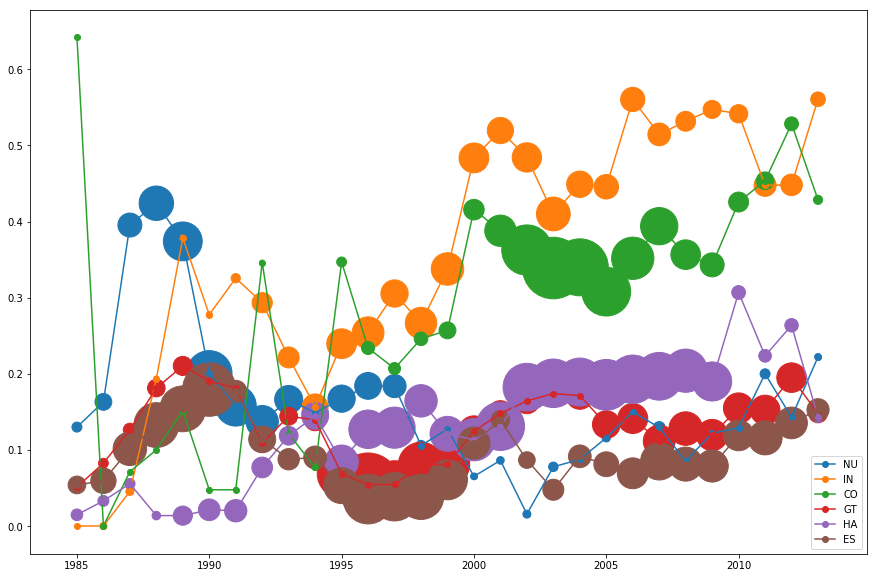

In [119]:
grp_nat = master_app.groupby('nat',as_index=False).dec.count()
grp_nat = grp_nat.sort_values('dec')

nats = grp_nat.nat[-7:-1]
plt.figure(figsize=(15,10))
for n in nats:
    df_mini = nat_yr_grantrate[nat_yr_grantrate.nat==n]
    plt.plot(df_mini.comp_year,df_mini.gr,'o-')
    plt.scatter(df_mini.comp_year,df_mini.gr,marker='o',s=df_mini.num_dec)
plt.legend(nats)
plt.show()

In [120]:
#visualize grant rate by year per judge

judge_yr_grantrate = master_app.groupby(['tracid','comp_year'],as_index=False).dec.agg({
    'gr': lambda x: (len(x[x =='GRANT'])/ ( len(x[x =='GRANT']) + len(x[x =='DENY']))),
    'num_dec': lambda x:( len(x[x =='GRANT']) + len(x[x =='DENY']))})



# Plot grant rate by judge over time for a few judges
### marker size indicates num decisions in that time period
### color indicates judge

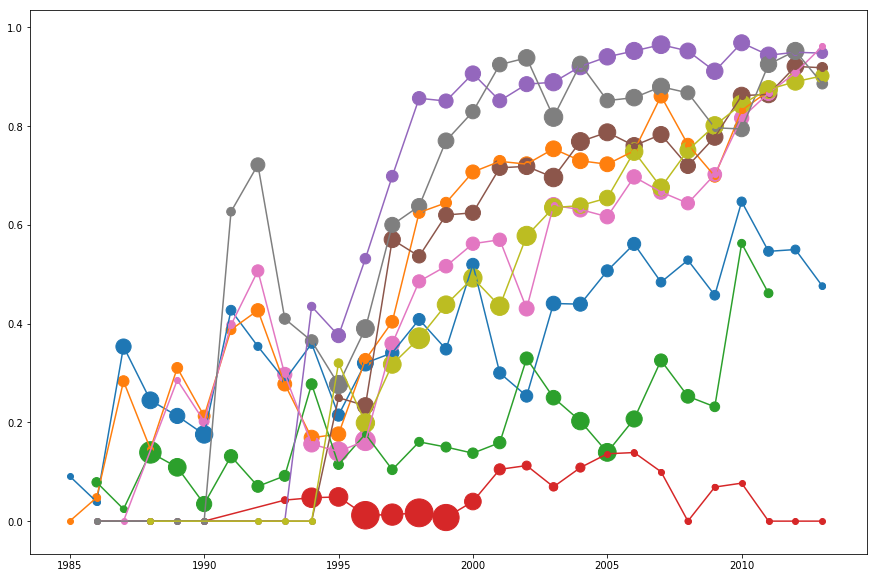

In [133]:
grp_j = master_app.groupby('tracid',as_index=False).dec.count()
grp_j = grp_j.sort_values('dec')

js = grp_j.tracid[-10:-1]
plt.figure(figsize=(15,10))
for j in js:
    df_mini = judge_yr_grantrate[judge_yr_grantrate.tracid==j]
    plt.plot(df_mini.comp_year,df_mini.gr,'o-')
    plt.scatter(df_mini.comp_year,df_mini.gr,marker='o',s=df_mini.num_dec)
plt.show()